In [1]:
import numpy as np
from scipy.stats import mode
import matplotlib.pyplot as plt

In [2]:
img = np.load('./data/FULL_CORE_image_arr.npy')
labels = np.load('./data/FULL_CORE_class_labels.npy')
depths = np.load('./data/FULL_CORE_depth_arr.npy')

In [3]:
length = depths[-1] - depths[0]
print(length)
approx_pp_ft = img.shape[0] / length
print(approx_pp_ft)
approx_pp_in = approx_pp_ft / 12
print(approx_pp_in)

413.59951093601376
1468.5849086846943
122.38207572372453


In [4]:
from coremdlr.utils.facies_utils import (make_labeled_frames,
                                            save_keras_model, load_keras_model)

/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Making  6074  patches...
At patch # 2000
At patch # 1000
At patch # 3000
At patch # 0
At patch # 5000
At patch # 6000
At patch # 4000
Label counts =  [(1, 710), (2, 4316), (3, 1048)]


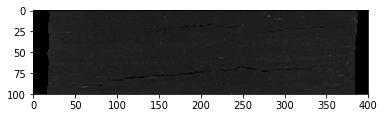

In [5]:
X_train, y_train = make_labeled_frames(img[:,:400], labels, 100, stride=100, shuffle=True)

In [6]:
X_train.shape, y_train.shape

((6074, 100, 400, 3), (6074,))

In [7]:
# if we can an error here, GPU is unseen
'''
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))
'''

"\nimport tensorflow as tf\nwith tf.device('/gpu:0'):\n    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')\n    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')\n    c = tf.matmul(a, b)\n\nwith tf.Session() as sess:\n    print (sess.run(c))\n"

In [8]:
# make an ImageDataGenerator
from keras import utils
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            shear_range=-5.0,
                            zoom_range=0.05,
                            fill_mode='constant', cval=0.0,
                            horizontal_flip=True,
                            validation_split=0.2)

n_classes = 3
y_train = utils.to_categorical(y_train, n_classes)
datagen.fit(X_train)

In [9]:
# Make a NN
from keras.applications import xception
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

xnet_base = xception.Xception(include_top=False, weights='imagenet', input_shape=(100,400,3))
x = xnet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

model = Model(inputs=xnet_base.input, outputs=predictions)

In [10]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [11]:
# first train new top layers
from keras.callbacks import EarlyStopping

for layer in xnet_base.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1])

epochs = 500
batch_size = 64     # only ~50% util --> try 64-ish
early_stop = EarlyStopping(monitor='loss', patience=3)
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train)/batch_size, epochs=epochs,
                    callbacks=[early_stop])

Epoch 1/500
95/94 [==============================] - 33s 349ms/step - loss: 0.6760 - acc: 0.7594 - f1: 0.7368
Epoch 2/500
95/94 [==============================] - 32s 342ms/step - loss: 0.5563 - acc: 0.7977 - f1: 0.7876
Epoch 3/500
95/94 [==============================] - 33s 347ms/step - loss: 0.5268 - acc: 0.8110 - f1: 0.8019
Epoch 4/500
95/94 [==============================] - 33s 346ms/step - loss: 0.5234 - acc: 0.8022 - f1: 0.7995
Epoch 5/500
95/94 [==============================] - 32s 341ms/step - loss: 0.4945 - acc: 0.8163 - f1: 0.8119
Epoch 6/500
95/94 [==============================] - 32s 340ms/step - loss: 0.4901 - acc: 0.8162 - f1: 0.8119
Epoch 7/500
95/94 [==============================] - 32s 341ms/step - loss: 0.4861 - acc: 0.8153 - f1: 0.8126
Epoch 8/500
95/94 [==============================] - 32s 341ms/step - loss: 0.4703 - acc: 0.8279 - f1: 0.8221
Epoch 9/500
95/94 [==============================] - 33s 348ms/step - loss: 0.4702 - acc: 0.8266 - f1: 0.8217
Epoch 10/5

In [14]:
save_keras_model(model, './saved_models/patchCNN_2')

In [15]:
# look at layers, decide how many to train
for i, layer in enumerate(xnet_base.layers):
   print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_1
13 block2_pool
14 batch_normalization_1
15 add_1
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_2
23 block3_pool
24 batch_normalization_2
25 add_2
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_3
33 block4_pool
34 batch_normalization_3
35 add_3
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_4
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepcon

In [16]:
# train the top two sepconv blocks now
for layer in model.layers[:115]:
   layer.trainable = False
for layer in model.layers[115:]:
   layer.trainable = True

# need to recompile
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1])

epochs = 500
batch_size = 64
early_stop = EarlyStopping(monitor='loss', patience=4)
model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train)/batch_size, epochs=epochs,
                    callbacks=[early_stop])

save_keras_model(model, './saved_models/patchCNN_2_top2blocks')

Epoch 1/500
95/94 [==============================] - 33s 345ms/step - loss: 0.5361 - acc: 0.8069 - f1: 0.7982
Epoch 2/500
95/94 [==============================] - 33s 345ms/step - loss: 0.4294 - acc: 0.8445 - f1: 0.8416
Epoch 3/500
95/94 [==============================] - 33s 345ms/step - loss: 0.3816 - acc: 0.8608 - f1: 0.8595
Epoch 4/500
95/94 [==============================] - 33s 343ms/step - loss: 0.3567 - acc: 0.8672 - f1: 0.8656
Epoch 5/500
95/94 [==============================] - 33s 343ms/step - loss: 0.3403 - acc: 0.8697 - f1: 0.8682
Epoch 6/500
95/94 [==============================] - 33s 343ms/step - loss: 0.3152 - acc: 0.8804 - f1: 0.8796
Epoch 7/500
95/94 [==============================] - 33s 345ms/step - loss: 0.3011 - acc: 0.8836 - f1: 0.8833
Epoch 8/500
95/94 [==============================] - 33s 350ms/step - loss: 0.2967 - acc: 0.8902 - f1: 0.8889
Epoch 9/500
95/94 [==============================] - 34s 354ms/step - loss: 0.2823 - acc: 0.8955 - f1: 0.8946
Epoch 10/5